# Introduction to a Wasserstein Generative Adversarial Network

## Prerequisites

### Knowledge
- https://arxiv.org/abs/1701.07875
### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

### Data

In [2]:
batch_size = 100

# Load the dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1. # [0, 2]
X_train = np.expand_dims(X_train, axis=3)

# Labels for real and fake examples
real = -np.ones((batch_size, 1))
fake = np.ones((batch_size, 1))

print(X_train.shape, np.min(X_train), np.max(X_train))

(60000, 28, 28, 1) -1.0 1.0


## WGAN for MNIST 

### Generator

In [3]:
def generator(): 
    model = tf.keras.Sequential([# Reshape input into 7x7x128 tensor via a fully connected layer
                                 tf.keras.layers.Dense(256 * 7 * 7, activation='relu'),
                                 tf.keras.layers.Reshape((7, 7,256)),
                                 # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
                                 tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'),
                                 tf.keras.layers.BatchNormalization(fused=False),
                                 tf.keras.layers.LeakyReLU(alpha=0),
                                 # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
                                 tf.keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'),
                                 tf.keras.layers.BatchNormalization(fused=False),
                                 tf.keras.layers.LeakyReLU(alpha=0),
                                 # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
                                 tf.keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'),
                                 tf.keras.layers.Activation('tanh')])
    return model

generator = generator()

### Critic

In [4]:
def critic():
    model = tf.keras.Sequential([# Convolutional layer, from 28x28x1 into 14x14x32 tensor
                                 tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same'),
                                 tf.keras.layers.LeakyReLU(alpha=0.2),
                                 # Convolutional layer, from 14x14x32 into 7x7x64 tensor
                                 tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding='same'),
                                 tf.keras.layers.BatchNormalization(fused=False),
                                 tf.keras.layers.LeakyReLU(alpha=0.2),
                                 # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
                                 tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding='same'),
                                 tf.keras.layers.BatchNormalization(fused=False),
                                 tf.keras.layers.LeakyReLU(alpha=0.2),
                                 # Flatten the tensor and apply sigmoid activation function
                                 tf.keras.layers.Flatten(),
                                 tf.keras.layers.Dense(1)])
    return model

critic = critic()

### Wasserstein loss

In [5]:
def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * y_pred)

### Training

In [6]:
generator_opt = tf.keras.optimizers.RMSprop(lr=0.00005)
critic_opt = tf.keras.optimizers.RMSprop(lr=0.00005)

When training the generator, you use

In [7]:
@tf.function
def train_critic(image, label):
    with tf.GradientTape() as tape:
        # calculate loss
        prediction = critic(image)
        loss = wasserstein_loss(y_true=label, y_pred=prediction)
        accuracy = tf.reduce_mean(tf.keras.metrics.binary_accuracy(y_true=label, y_pred=prediction))

        # gradient descent and only update discriminator
        gradient = tape.gradient(loss, critic.trainable_variables)
        critic_opt.apply_gradients(zip(gradient, critic.trainable_variables))
    return loss, accuracy

In [8]:
@tf.function
def train_generator(z_sample, label):
    with tf.GradientTape() as tape:
        image = generator(z_sample)
        prediction = critic(image)
        loss = wasserstein_loss(y_true=label, y_pred=prediction)
        # gradient descent and only update generator
        gradients = tape.gradient(loss, generator.trainable_variables)
        generator_opt.apply_gradients(zip(gradients, generator.trainable_variables))
    return loss

    0/10000 [..............................] - ETA: 0sIteration 0 d_loss 0.00014433755565593947 g_loss -0.00028281788886478 accuracy 0.0


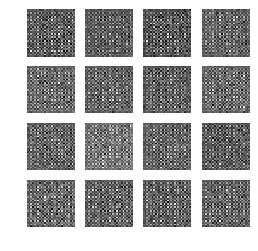

 2000/10000 [=====>........................] - ETA: 1:21:42Iteration 2000 d_loss -0.00029137098574041236 g_loss 0.001173112510464036 accuracy 0.0


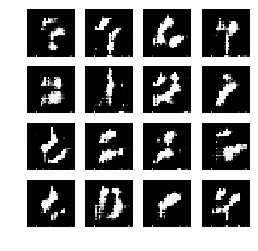

 4000/10000 [===========>..................] - ETA: 1:01:04Iteration 4000 d_loss -1.4929392573609056e-07 g_loss 8.960906610051574e-05 accuracy 0.0


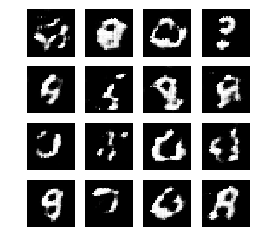

 6000/10000 [=================>............] - ETA: 40:41Iteration 6000 d_loss 1.1479029228230828e-05 g_loss -4.2161756519710664e-05 accuracy 0.0


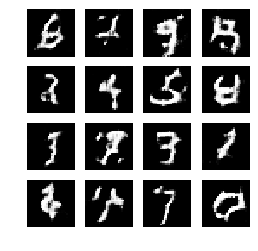

 8000/10000 [=======================>......] - ETA: 20:20Iteration 8000 d_loss 1.0186033605425558e-05 g_loss -5.3073563039818414e-05 accuracy 0.0


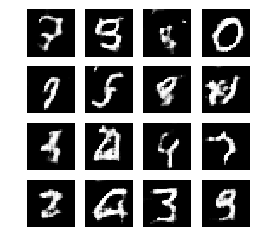

 9999/10000 [============================>.] - ETA: 0s

In [9]:
# init lists for losses and accuracies
d_losses, d_accuracies, g_losses = [], [], []

# defining the z dimension
z_dim = 100

# Following parameter and optimizer set as recommended in paper
n_critic = 5
clip_value = 0.01

ITERATIONS = 10000
prog = tf.keras.utils.Progbar(ITERATIONS)
for i in range(ITERATIONS):
    
    for _ in range(n_critic):
        # pick a random sample from the datas
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        image = X_train[idx]

        # Generate a batch of fake images
        z_sample = np.random.normal(0, 1, (batch_size, z_dim))
        gen_image = generator(z_sample)

        # Discriminator loss and train discriminator on fake and real images
        d_loss_real, d_accuracy_real = train_critic(image, real)
        d_loss_fake, d_accuracy_fake = train_critic(gen_image, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        d_accuracy = 0.5 * np.add(d_accuracy_real, d_accuracy_fake)

        # Clip critic weights
        for l in critic.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -clip_value, clip_value) for w in weights]
            l.set_weights(weights)        
        
    # Generator loss
    g_loss = train_generator(z_sample, real).numpy()
    prog.update(i)
    
    # visualization
    if i % 2000 == 0:
        print("Iteration", i, "d_loss", d_loss, "g_loss", g_loss, "accuracy", d_accuracy)
        image_grid_rows=4
        image_grid_columns=4

        # Sample random noise
        z_sample = np.random.normal(0, 1, 
                  (image_grid_rows * image_grid_columns, z_dim))

        # Generate images from random noise 
        gen_imgs = generator(z_sample)
        # Rescale images to 0-1
        gen_imgs = 0.5 * gen_imgs + 0.5

        # Set image grid
        fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                        figsize=(image_grid_rows,image_grid_columns), sharey=True, sharex=True)
        cnt = 0
        for m in range(image_grid_rows):
            for n in range(image_grid_columns):
                # Output image grid
                axs[m,n].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[m,n].axis('off')
                cnt += 1
        plt.show()
        
        d_losses.append(d_loss)
        d_accuracies.append(d_accuracy)
        g_losses.append(g_loss)


### Visualization

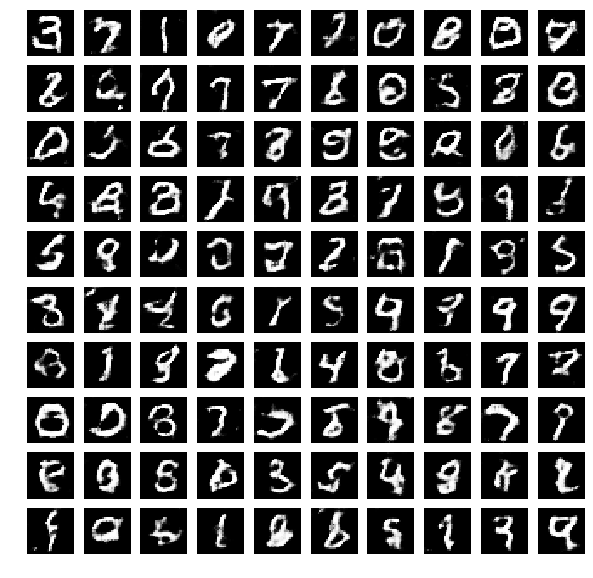

In [10]:
image_grid_rows=10
image_grid_columns=10

# Sample random noise
z_sample = np.random.normal(0, 1, 
          (image_grid_rows * image_grid_columns, z_dim))

# Generate images from random noise 
gen_imgs = generator(z_sample)
# Rescale images to 0-1
gen_imgs = 0.5 * gen_imgs + 0.5

# Set image grid
fig, axs = plt.subplots(image_grid_rows, image_grid_columns, 
                                figsize=(10,10), sharey=True, sharex=True)
cnt = 0
for i in range(image_grid_rows):
    for j in range(image_grid_columns):
        # Output image grid
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1

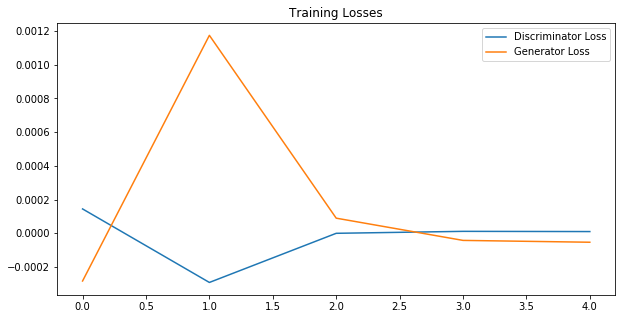

In [11]:
# Plot training losses for Discriminator and Generator
d_losses = np.array(d_losses)
g_losses = np.array(g_losses)
plt.figure(figsize=(10,5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.title("Training Losses")
plt.legend()

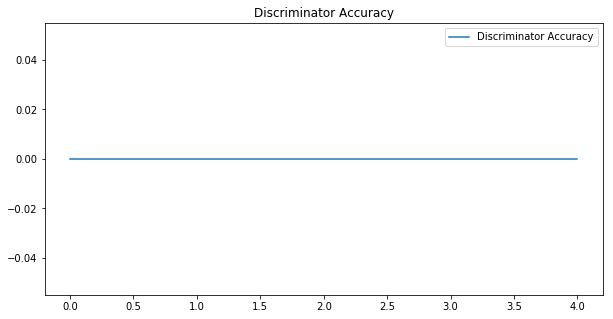

In [12]:
accuracies = np.array(d_accuracies)

# Plot Discriminator accuracy
plt.figure(figsize=(10,5))
plt.plot(accuracies, label="Discriminator Accuracy")
plt.title("Discriminator Accuracy")
plt.legend()